<h2> <b>목차</b> </h2>
<h3> Ⅰ. 연도별 선박가격 추이 </h3>
<h3> Ⅱ. 선가 변화율 모형을 이용한 시뮬레이션 </h3>
<ol>
    <li> 선령 10년 선박의 월별 가격변화율 </li>
    <li> 손해액 시뮬레이션 </li>
</ol>
<h2>----------------------------------------------------------------------------------------------------------------------------</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
# Data Importing
prices = pd.read_excel('./rvi/Supra prices.xlsx')

## Ⅰ. 연도별 선박가격 추이

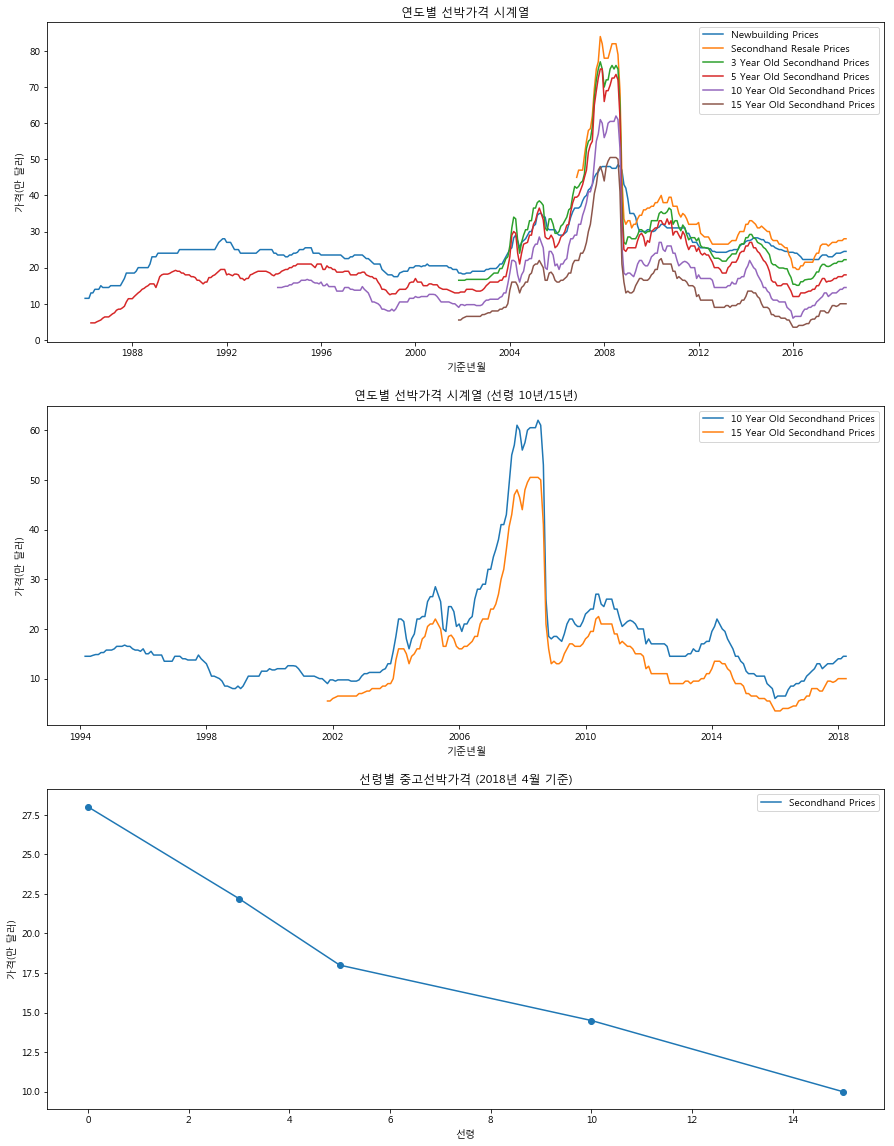

In [13]:
fig, ax = plt.subplots(3,1,figsize=(15,20))
prices.columns = ['Date','NB','Resale','3y','5y','10y','15y']

ax[0].plot(prices['Date'], prices['NB'], label='Newbuilding Prices')
ax[0].plot(prices['Date'], prices['Resale'], label='Secondhand Resale Prices')
ax[0].plot(prices['Date'], prices['3y'], label='3 Year Old Secondhand Prices')
ax[0].plot(prices['Date'], prices['5y'], label='5 Year Old Secondhand Prices')
ax[0].plot(prices['Date'], prices['10y'], label='10 Year Old Secondhand Prices')
ax[0].plot(prices['Date'], prices['15y'], label='15 Year Old Secondhand Prices')
ax[0].set_xlabel('기준년월')
ax[0].set_ylabel('가격(백만 달러)')
ax[0].set_title('연도별 선박가격 시계열')
ax[0].legend()

ax[1].plot(prices['Date'], prices['10y'], label='10 Year Old Secondhand Prices')
ax[1].plot(prices['Date'], prices['15y'], label='15 Year Old Secondhand Prices')
ax[1].set_xlabel('기준년월')
ax[1].set_ylabel('가격(백만 달러)')
ax[1].set_title('연도별 선박가격 시계열 (선령 10년/15년)')
ax[1].legend()

ax[2].plot([0,3,5,10,15], prices.iloc[0,2:], label='Secondhand Prices')
ax[2].scatter([0,3,5,10,15], prices.iloc[0,2:], label='')
ax[2].set_xlabel('선령')
ax[2].set_ylabel('가격(백만 달러)')
ax[2].set_title('선령별 중고선박가격 (2018년 4월 기준)')
ax[2].legend()

plt.show()

## Ⅱ. 선가 변화율 모형을 이용한 시뮬레이션

### 1. 선령 10년 선박의 월별 가격변화율

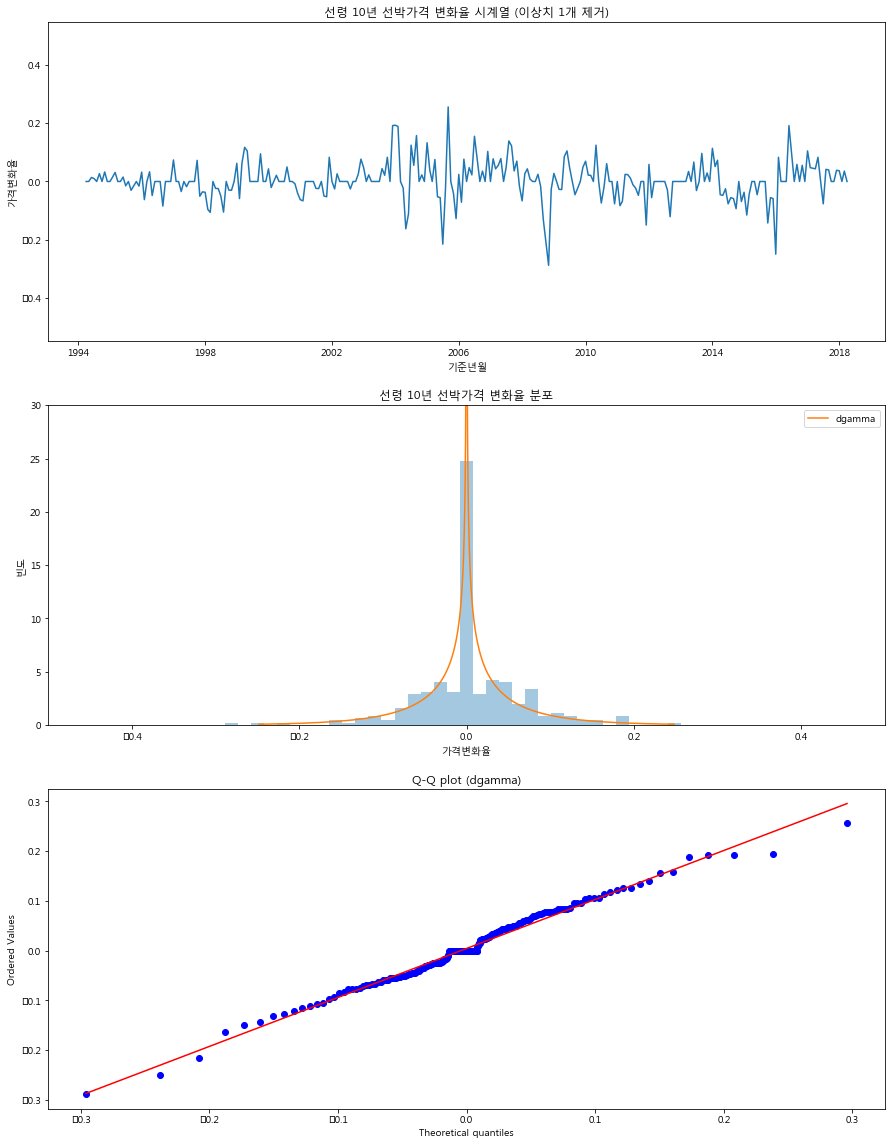


선택된 [선령 10년 선박의 월별 가격변화율] 모형

  Y ~ dgamma(a=0.5459, loc=0.0000, scale=0.0718)



In [14]:
fig, ax = plt.subplots(3,1,figsize=(15,20))

prices_10y = prices.set_index('Date')['10y']
prices_10y_inc = (prices_10y/prices_10y.shift(-1)-1).dropna()
prices_10y_inc = prices_10y_inc[prices_10y_inc>-0.5]   # Outlier (1개 제거)

# 시계열
ax[0].plot(prices_10y_inc)
ax[0].set_xlabel('기준년월')
ax[0].set_ylabel('가격변화율')
ax[0].set_ylim(-0.55,0.55)
ax[0].set_title('선령 10년 선박가격 변화율 시계열 (이상치 1개 제거)')



# 분포
dist_name = 'dgamma'
dist = getattr(scipy.stats, dist_name)
param = dist.fit(prices_10y_inc)
rv = dist(*param[:-2], loc=param[-2], scale=param[-1])
mle = np.sum(np.log(rv.pdf(prices_10y_inc)))
k = len(param)
aic = -2*mle + 2*k
bic = -2*mle + k*np.log(n)

x = np.linspace(rv.ppf(0.005), rv.ppf(0.995), 1000)
pdf_fitted = rv.pdf(x)
sns.distplot(prices_10y_inc, ax=ax[1], kde=False, norm_hist=True)
ax[1].plot(x, pdf_fitted, label=dist_name)
ax[1].set_xlabel('가격변화율')
ax[1].set_ylabel('빈도')
ax[1].set_title('선령 10년 선박가격 변화율 분포')
ax[1].set_xlim(-0.5,0.5)
ax[1].set_ylim(0,30)
ax[1].legend()

# Q-Q plot
res = scipy.stats.probplot(prices_10y_inc, dist=dist, sparams=(*param[:-2],param[-2],param[-1]), plot=ax[2])
ax[2].set_title('Q-Q plot ({:})'.format(dist_name))

plt.show()

# 텍스트 출력
print('\n선택된 [선령 10년 선박의 월별 가격변화율] 모형\n')
print('  Y ~ {:}(a={:.4f}, loc={:.4f}, scale={:.4f})\n'.format(dist_name,param[-3],param[-2],param[-1]))
#print('{:>8}\'s Loglikehood = {:.2f}   AIC = {:.2f}   BIC = {:.2f}'.format(dist_name, mle, aic, bic))

### 2. 손해액 시뮬레이션

보험료 : 0.84만 달러
선가 변화율 모형 : dgamma
사고확률 : 51.96%
사고당 평균손해액 : 2.92만 달러
기대손실액 : 1.52만 달러
Value-at-Risk(99.5%) : 7.73만 달러


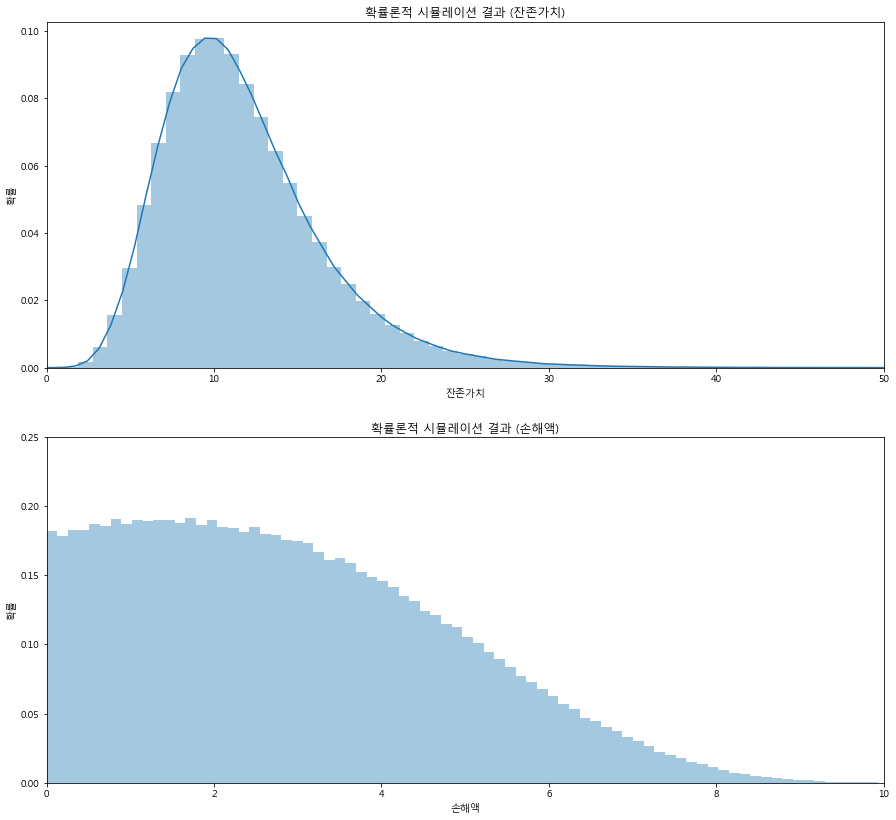

In [17]:
fig, ax = plt.subplots(2,1,figsize=(15,14))

# 옵션
n = 1000000
term = 36
current_value = 13.4
value = 13.1
adj = current_value/(prices.iloc[0,4]*3/5+prices.iloc[0,5]*2/5) # 가격 보정
cover_rate = 0.85
cover = value*cover_rate
rate = 0.075
premium = cover*rate


dist_name = 'dgamma'
dist = getattr(scipy.stats, dist_name)
param = dist.fit(prices_10y_inc)
Y = dist(*param[:-2], loc=param[-2], scale=param[-1])
resids = adj*prices.iloc[0,5]*np.prod(1+Y.rvs(size=(term,n)), axis=0)
simulation = np.fmax(cover - resids,0)
f = np.count_nonzero(simulation)
freq = f/n
claims = simulation[simulation>0]
sev = np.sum(claims)/f
var = np.percentile(simulation,99.5)
result = [dist_name,freq,sev,freq*sev,var]

sns.distplot(resids, bins=100, norm_hist=True, ax=ax[0])
ax[0].set_xlabel('잔존가치')
ax[0].set_ylabel('확률')
ax[0].set_xlim(0,50)
ax[0].set_title('확률론적 시뮬레이션 결과 (잔존가치)'.format(dist_name))

sns.distplot(claims, bins=100, kde=False, norm_hist=True, ax=ax[1])
ax[1].set_xlabel('손해액')
ax[1].set_ylabel('확률')
ax[1].set_xlim(0,10)
ax[1].set_ylim(0,0.25)
ax[1].set_title('확률론적 시뮬레이션 결과 (손해액)'.format(dist_name))

print('보험료 : {:.2f}만 달러'.format(premium))
print('선가 변화율 모형 : {:5}\n사고확률 : {:.2%}\n사고당 평균손해액 : {:.2f}만 달러\n기대손실액 : {:.2f}만 달러\nValue-at-Risk(99.5%) : {:.2f}만 달러'.format(result[0],result[1],result[2],result[3],result[4]))
plt.show()

### 3. 민감도 분석

In [45]:
def stressTest(cover):
    n = 1000000
    term = 36
    current_value = 13.4

    adj = current_value/(prices.iloc[0,4]*3/5+prices.iloc[0,5]*2/5) # 가격 보정
    rate = 0.075
    premium = cover*rate

    dist_name = 'dgamma'
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(prices_10y_inc)
    Y = dist(*param[:-2], loc=param[-2], scale=param[-1])
    resids = adj*prices.iloc[0,5]*np.prod(1+Y.rvs(size=(term,n)), axis=0)
    simulation = np.fmax(cover - resids,0)
    f = np.count_nonzero(simulation)
    freq = f/n
    claims = simulation[simulation>0]
    sev = np.sum(claims)/f
    var = np.percentile(simulation,99.5)
    result = [cover,freq,sev,freq*sev,freq*sev/premium,var]
    return result    
result = []

value = 13.1
cover_rate = 0.85
cover = value*cover_rate
for i in np.arange(cover,5,-1):
    result.append(stressTest(i))
result = pd.DataFrame(result, columns = ['보장가액','사고확률','사고당 평균손해액',' 기대손해액','예상손해율','VaR(99.5%)'])
result

,보장가액,사고확률,사고당 평균손해액,기대손해액,예상손해율,VaR(99.5%)
0,11.13,0.52,2.92,1.52,1.82,7.72
1,10.13,0.42,2.47,1.05,1.38,6.71
2,9.13,0.32,2.06,0.67,0.98,5.71
3,8.13,0.23,1.70,0.39,0.65,4.71
4,7.13,0.15,1.38,0.20,0.38,3.72
5,6.13,0.08,1.11,0.09,0.20,2.73
6,5.13,0.04,0.87,0.03,0.09,1.71


In [18]:
import codecs
from bs4 import BeautifulSoup

# 파일 불러오기
f = codecs.open('C:/Users/noilkwon/Downloads/180520_Bulkcarrier_final.html','r', 'utf-8')
soup = BeautifulSoup(f.read(),'html.parser')
f.close()

# 모든 input 삭제
for div in soup.findAll('div', {"class","input"}):
    div.decompose()
    
# 파일로 저장
html = soup.prettify('utf-8')
with open('output.html', 'wb') as file:
    file.write(html)